In [24]:
# Cell 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import joblib
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,5)
sns.set_style('whitegrid')

In [25]:
# Cell 2
DATA_PATH = r"C:\Users\asus\Desktop\Masters Project & Thesis\Master Projects\time series project rossman\train.csv"
df = pd.read_csv(DATA_PATH, parse_dates=['Date'])
df.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Load data

In [ ]:
# Cell 3
print("Columns:", df.columns.tolist())
# Ensuring  expected columns exist
assert 'Date' in df.columns, "No Date column"
assert 'Store' in df.columns, "No Store column"
# Standardize names
df.rename(columns={'Sales':'sales'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])


Columns: ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']


In [ ]:
# Cell 4
STORE = 1   # We can change the store number as per our Convenience
store_df = df[df['Store']==STORE].copy()
ts = store_df.set_index('Date').resample('D')['sales'].sum().fillna(0)
ts.index.name = 'date'
ts.head()


date
2013-01-01       0
2013-01-02    5530
2013-01-03    4327
2013-01-04    4486
2013-01-05    4997
Freq: D, Name: sales, dtype: int64

In [28]:
# Cell 5
def adf_test(series):
    res = adfuller(series)
    out = pd.Series(res[0:4], index=['ADF Stat','p-value','# lags used','# nobs'])
    for k,v in res[4].items():
        out[f'crit {k}'] = v
    return out

print(adf_test(ts))


ADF Stat        -4.368104
p-value          0.000338
# lags used     21.000000
# nobs         920.000000
crit 1%         -3.437478
crit 5%         -2.864687
crit 10%        -2.568445
dtype: float64


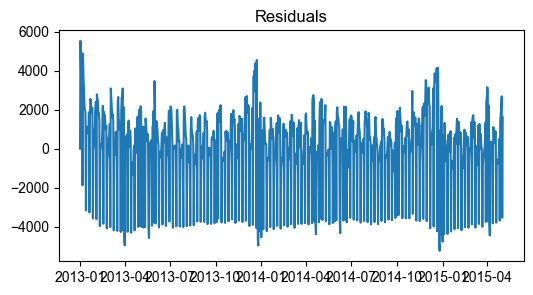

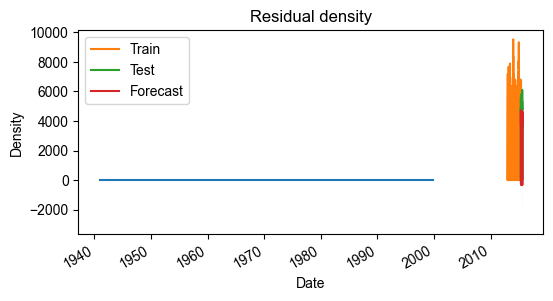

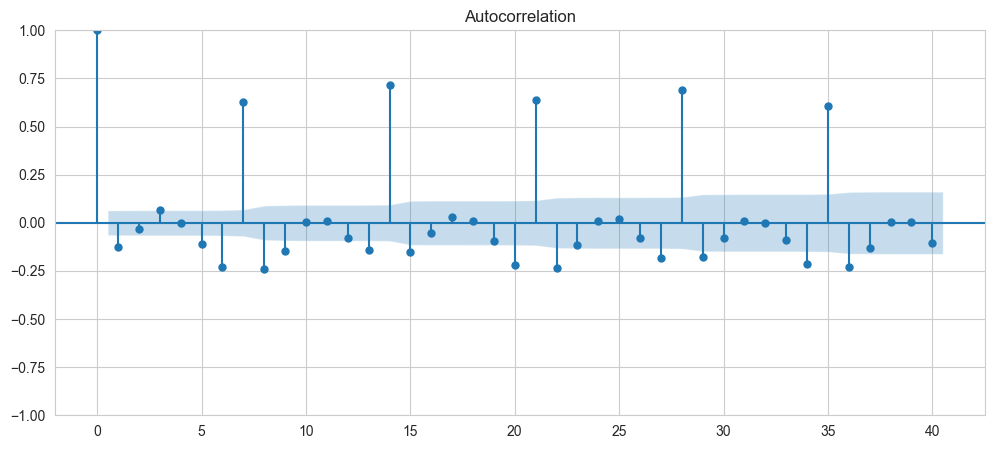

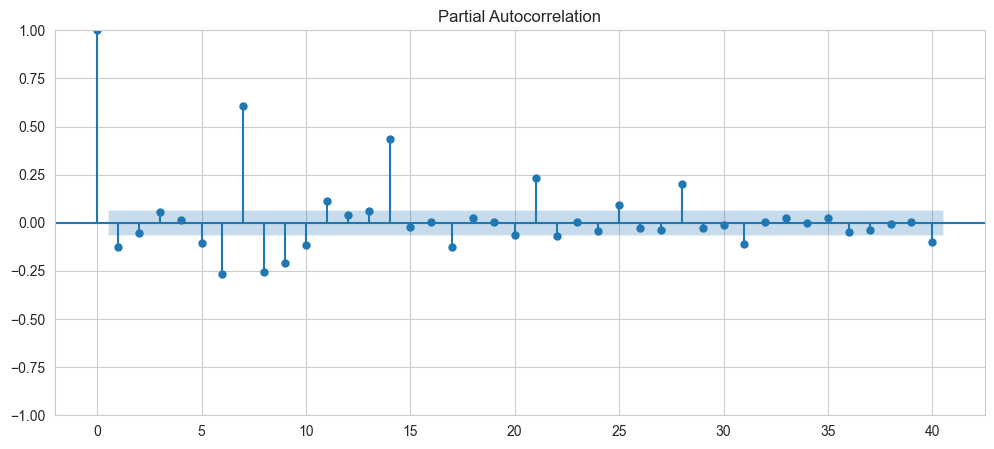

In [29]:
# Cell 6
plot_acf(ts, lags=40); plt.show()
plot_pacf(ts, lags=40); plt.show()



In [ ]:
# Cell 7
import itertools
p = q = range(0,3)    # small grid for speed; increase if needed
d = [0,1]
best_aic = np.inf
best_order = None
best_seasonal = None

#  including weekly seasonality
seasonal = [(0,0,0,0), (1,0,1,7)]
for order in itertools.product(p, d, q):
    for s in seasonal:
        try:
            model = SARIMAX(ts, order=order, seasonal_order=s, enforce_stationarity=False, enforce_invertibility=False)
            res = model.fit(disp=False)
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = order
                best_seasonal = s
        except Exception:
            continue

best_aic, best_order, best_seasonal



(np.float64(15811.921281546502), (2, 0, 0), (1, 0, 1, 7))

In [31]:
# Cell 8
order = best_order
seasonal_order = best_seasonal
print("Fitting SARIMAX with order", order, "seasonal", seasonal_order)
model = SARIMAX(ts, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary())
# Save model
joblib.dump(res, 'outputs/sarimax_store{}_model.pkl'.format(STORE))


Fitting SARIMAX with order (2, 0, 0) seasonal (1, 0, 1, 7)
                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                  942
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -7900.961
Date:                             Fri, 05 Sep 2025   AIC                          15811.921
Time:                                     16:39:16   BIC                          15836.113
Sample:                                 01-01-2013   HQIC                         15821.147
                                      - 07-31-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2226      0.018     12.059    

['outputs/sarimax_store1_model.pkl']

In [ ]:
# Cell 9
h = 90  # forecast horizon
train = ts[:-h]
test = ts[-h:]


model_train = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
fc = model_train.get_forecast(steps=h)
pred = fc.predicted_mean
ci = fc.conf_int()

# metrics (exclude where actual==0 for MAPE)
mae = mean_absolute_error(test, pred)
rmse = math.sqrt(mean_squared_error(test, pred))
mask = test>0
mape = (np.mean(np.abs((test[mask] - pred[mask]) / test[mask]))*100) if mask.sum()>0 else np.nan

print("MAE:", round(mae,2), "RMSE:", round(rmse,2), "MAPE%:", round(mape,2))



MAE: 658.13 RMSE: 1024.97 MAPE%: 14.2


In [ ]:
# Cell 10
resid = model_train.resid
plt.plot(resid); plt.title('Residuals'); plt.show()
resid.plot(kind='kde'); plt.title('Residual density'); plt.show()
# Ljung-Box
lb = acorr_ljungbox(resid, lags=[10], return_df=True)
print("Ljung-Box p-value (lag10):", lb['lb_pvalue'].values[0])


2025-09-05 16:30:56.029 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-05 16:30:56.032 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-05 16:30:56.035 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-05 16:31:01.121 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-05 16:31:03.832 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-05 16:31:03.834 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-05 16:31:04.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-05 16:31:05.033 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

False

In [34]:
# Cell 11
future_model = SARIMAX(ts, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
future = future_model.get_forecast(steps=h)
future_mean = future.predicted_mean
future_ci = future.conf_int()

future_index = pd.date_range(start=ts.index[-1] + timedelta(days=1), periods=h, freq='D')
forecast_df = pd.DataFrame({
    'date': future_index,
    'forecast': future_mean.values,
    'lower_ci': future_ci.iloc[:,0].values,
    'upper_ci': future_ci.iloc[:,1].values
}).set_index('date')

forecast_df.to_csv('outputs/forecast_store{}_arima.csv'.format(STORE))
print("Saved outputs/forecast_store{}_arima.csv".format(STORE))


Saved outputs/forecast_store1_arima.csv


In [20]:
#SARIMAX modeling (manual AIC-based tuning example)
# Changing  (p,d,q)(P,D,Q,7) to optimize
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7),
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                  852
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -7091.331
Date:                           Fri, 05 Sep 2025   AIC                          14192.662
Time:                                   16:31:24   BIC                          14216.300
Sample:                               01-01-2013   HQIC                         14201.724
                                    - 05-02-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1963      0.019     10.595      0.000       0.160       0.233
ma.L1         -0.9511      0.009   -109.677

In [21]:
# Save outputs
os.makedirs('outputs', exist_ok=True)
forecast_df.to_csv(f'outputs/forecast_store{STORE}.csv')
joblib.dump(full_model, f'outputs/sarimax_store{STORE}.pkl')
print("Forecast and model saved.")

Forecast and model saved.


In [22]:
# Function to forecast multiple stores
def forecast_store(df, store, forecast_days=90):
    ts = df[df['store']==store].copy().set_index('Date')['demand'].sort_index()
    ts = ts.resample('D').sum().fillna(0)
    train = ts
    model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7),
                    enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    future_pred = model.get_forecast(steps=forecast_days)
    future_mean = future_pred.predicted_mean
    future_ci = future_pred.conf_int()
    future_index = pd.date_range(start=ts.index[-1]+timedelta(days=1), periods=forecast_days, freq='D')
    out = pd.DataFrame({'forecast': future_mean.values}, index=future_index)
    out['lower_ci'] = future_ci.iloc[:,0].values
    out['upper_ci'] = future_ci.iloc[:,1].values
    return out, model
